In [949]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.metrics.distance import edit_distance

from textwrap import wrap

# Etape 1 - Scrapping chart

In [950]:
#Load
charts = pd.read_csv("../etapes/1 - scrapping chart/charts.csv", encoding="utf-8-sig")

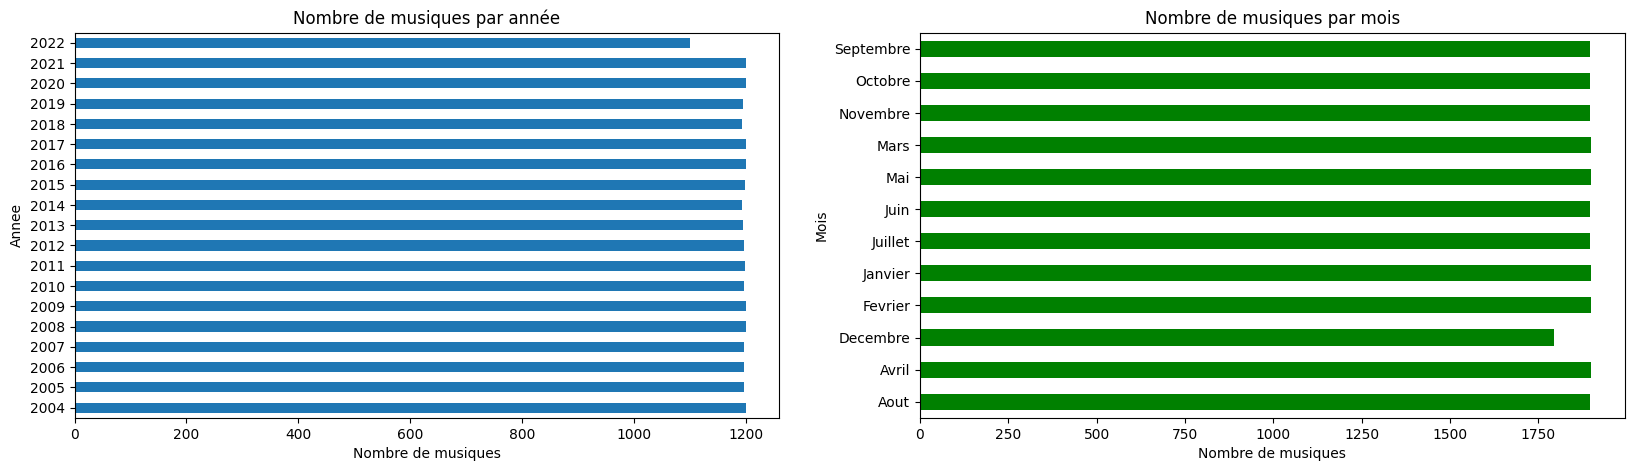

In [951]:
#Donnée par année
fig, ax = plt.subplots(1, 2, figsize=(20,5))
charts.groupby("Annee")["Music"].count().plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musiques par année", xlabel="Nombre de musiques")

charts.groupby("Mois")["Music"].count().plot.barh(ax=ax[1], color="green")
ax[1].set(title="Nombre de musiques par mois", xlabel="Nombre de musiques")

plt.show()

# Etape 2 - Cleanning chart

In [952]:
#Load
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

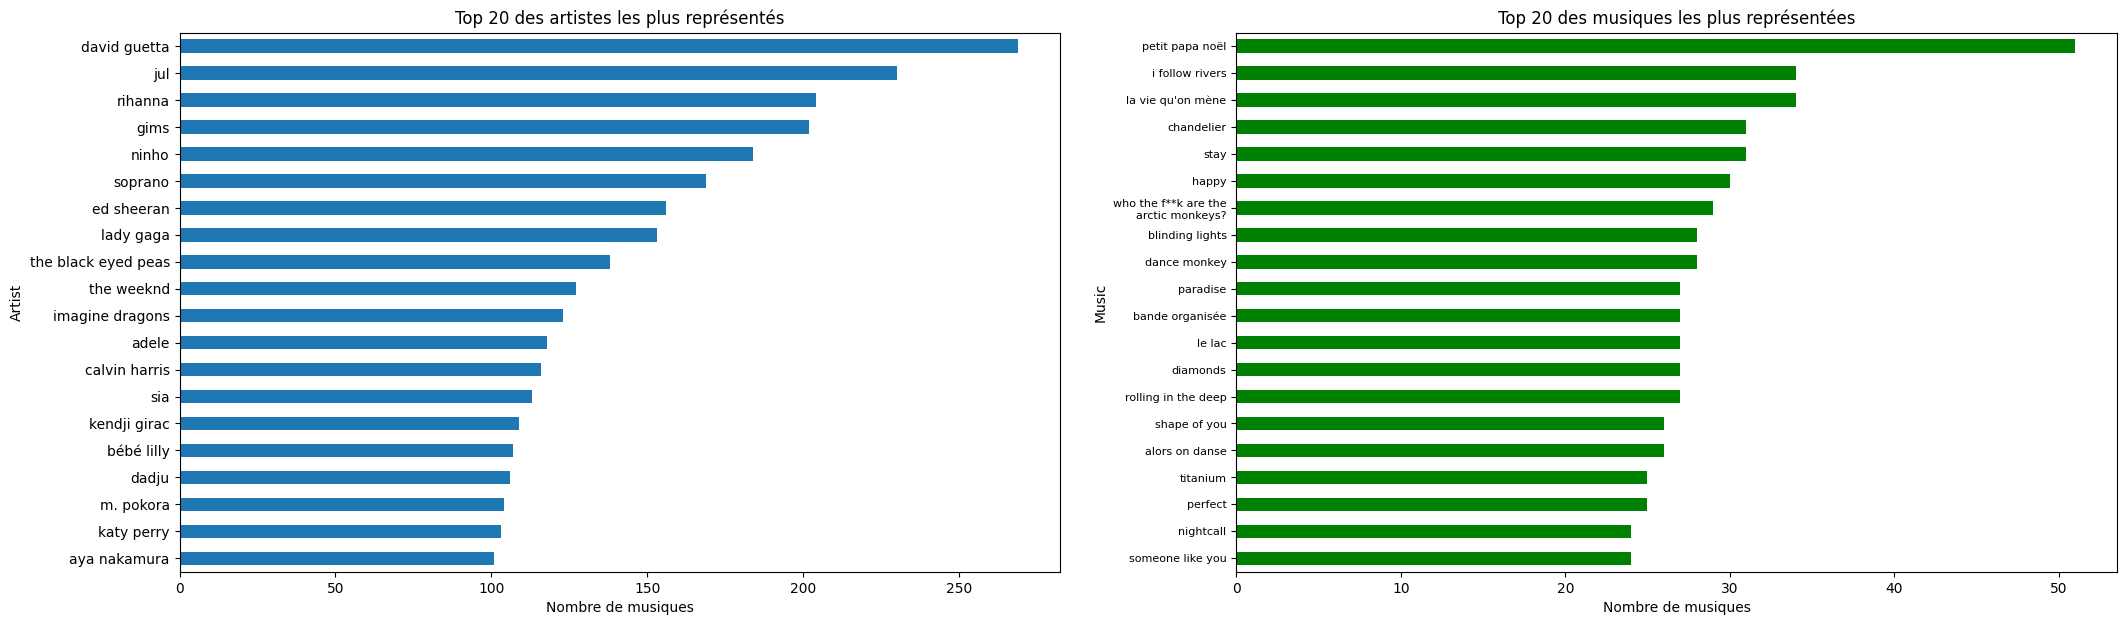

In [953]:
fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Top 20 des artistes les plus représentés", xlabel="Nombre de musiques")

charts.groupby("Music")["Artist"].count().sort_values()[-20:].plot.barh(ax=ax[1], color="green")
ax[1].set(title="Top 20 des musiques les plus représentées", xlabel="Nombre de musiques")
ax[1].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

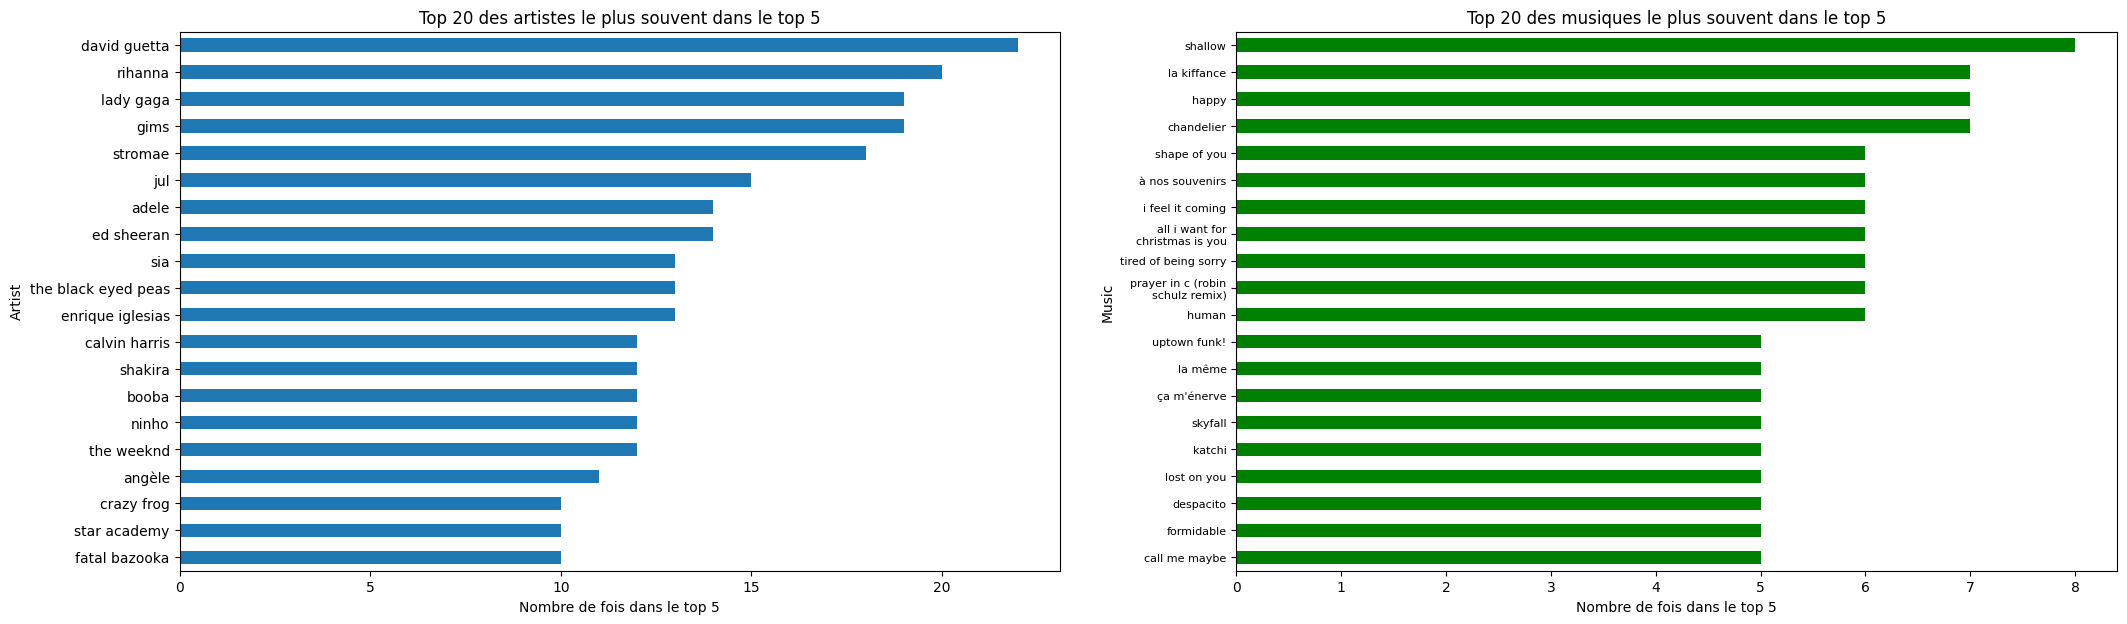

In [954]:
top = 5

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("Artist")["Rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top 20 des artistes le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")

charts.groupby("Music")["Rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values()[-20:].plot.barh(color="green", ax=ax[1])
ax[1].set(title=f"Top 20 des musiques le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")
ax[1].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

David Guetta est l'artiste qui a eu le souvent ses musiques dans les top 5 français. </br>
Shallow est la musique qui est revenu le plus souvent dans le top 5.

In [955]:
charts_c = charts.copy()
charts_c.drop(columns=["Rank", "Annee", "Mois"], inplace=True)
charts_c.drop_duplicates(inplace=True)

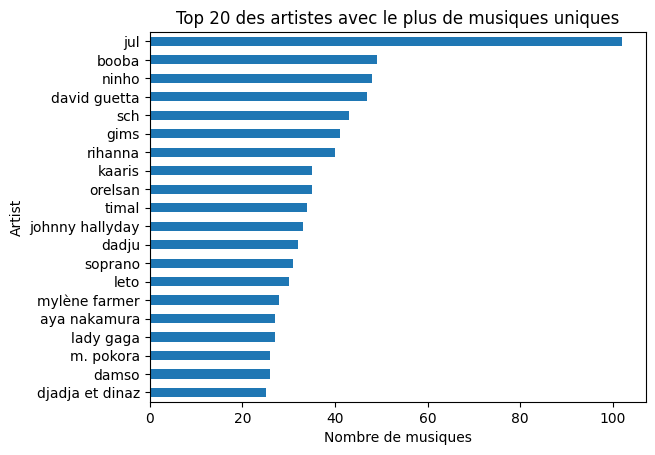

In [956]:
charts_c.groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes avec le plus de musiques uniques")
plt.xlabel("Nombre de musiques")
plt.show()

Jul est l'artiste avec le plus de musique unique dans le top 100 depuis 2004

# Etape 3 : Scrapping artist data

In [957]:
#Load
artist = pd.read_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig", index_col=0)

## Donnée récoloté

In [958]:
artist.value_counts("Artist_wiki").value_counts() #Aucune page en wiki en double, ce qui est un bon signe !

1     1699
17       1
dtype: int64

In [959]:
charts_c = charts.copy().drop(columns=["Rank", "Annee", "Mois"]).drop_duplicates()
charts_c = charts_c.merge(artist, on="Artist", how="left")

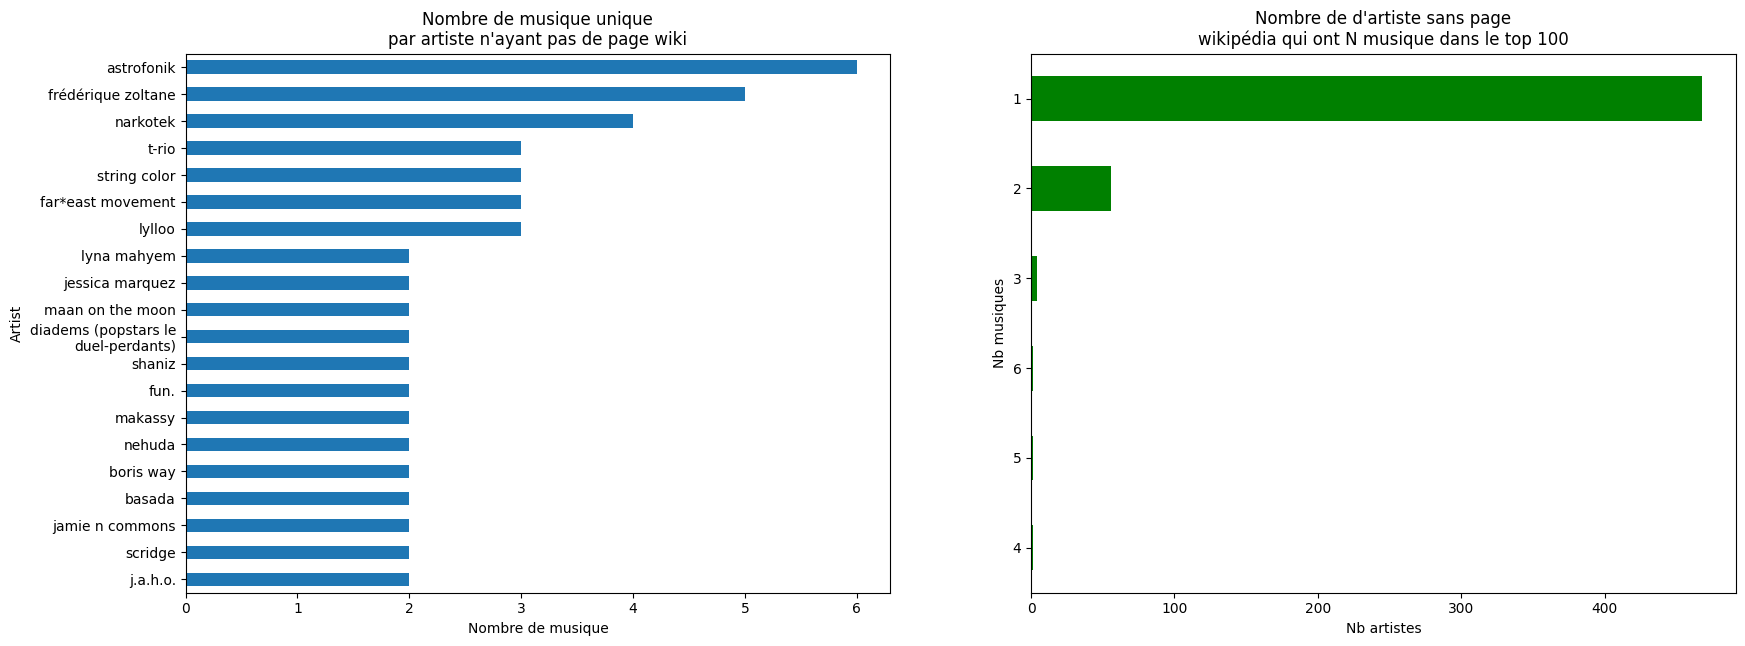

In [960]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

charts_c[charts_c["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musique unique\npar artiste n'ayant pas de page wiki", xlabel="Nombre de musique")
ax[0].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[0].get_yticklabels()])


charts_c[charts_c["Artist_wiki"].isna()].groupby("Artist")["Music"].count().value_counts()[::-1].plot.barh(ax=ax[1], color="green")
ax[1].set(xlabel="Nb artistes", ylabel="Nb musiques", title="Nombre de d'artiste sans page\nwikipédia qui ont N musique dans le top 100")
plt.show()

On remarque qu'il y a beaucoup d'artistes qui n'ont fait qu'une ou deux musiques populaires, ce qui parait logique de ne pas trouver beaucoup d'information sur eux. </br>
Seul quelques artistes sortent du lot, et après recherche, soit l'artiste n'est pas français, soit il y a trop peu d'infos sur eux.

In [961]:
np.round(artist[artist["Artist_wiki"].isna()].shape[0] / artist.shape[0], 2) # 24% des artistes n'ont pas de page en wiki

0.24

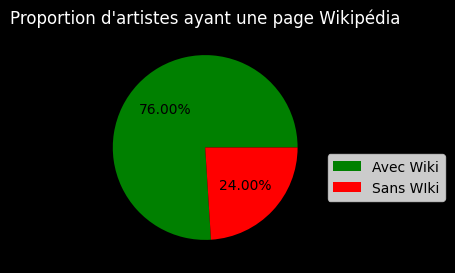

In [962]:
artist["Artist_wiki"].isna().value_counts(normalize=True).round(2).plot.pie(autopct="%.2f%%", figsize=(3,3), colors=["green", "red"])
plt.title("Proportion d'artistes ayant une page Wikipédia", color='white')
plt.gcf().set_facecolor('black')
plt.legend(["Avec Wiki", "Sans WIki"], bbox_to_anchor=(1, 0.5))

In [963]:
np.round(charts_c[charts_c["Artist_wiki"].isna()].shape[0]/charts_c.shape[0], 2) # 10% des musiques n'ont pas d'info sur leur artistes

0.1

In [964]:
artist = artist[~artist["Artist_wiki"].isna()]

In [965]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    if wiki == "MANUEL":
        return 0

    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

In [966]:
artist["distance"] = artist.apply(lambda x: calc_dist(x.name, x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x.name), axis=1)

In [967]:
artist.sort_values("distance_norm", ascending=False).head() #Nos distances sont bonnes

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm
Artist,,,,,,,,,
ouf le prof,Ouf le prof !,NaN,france,NaN,NaN,france,ouf le prof !,2,0.181818
simon & garfunkel,Simon and Garfunkel,NaN,états-unis,NaN,NaN,états-unis,simon and garfunkel [ˈsaɪmən ən gɑrfʌnkəl] est...,3,0.176471
tiesto,Tiësto,17 janvier 1969 (53 ans)bréda,NaN,NaN,néerlandaise,NaN,"tiësto, nom de scène de tijs michiel verwest, ...",1,0.166667
gullia,Gulli,NaN,NaN,NaN,NaN,france,NaN,1,0.166667
sliimy,Slimmy,"rio tinto, gondomar (portugal)",NaN,NaN,NaN,NaN,NaN,1,0.166667


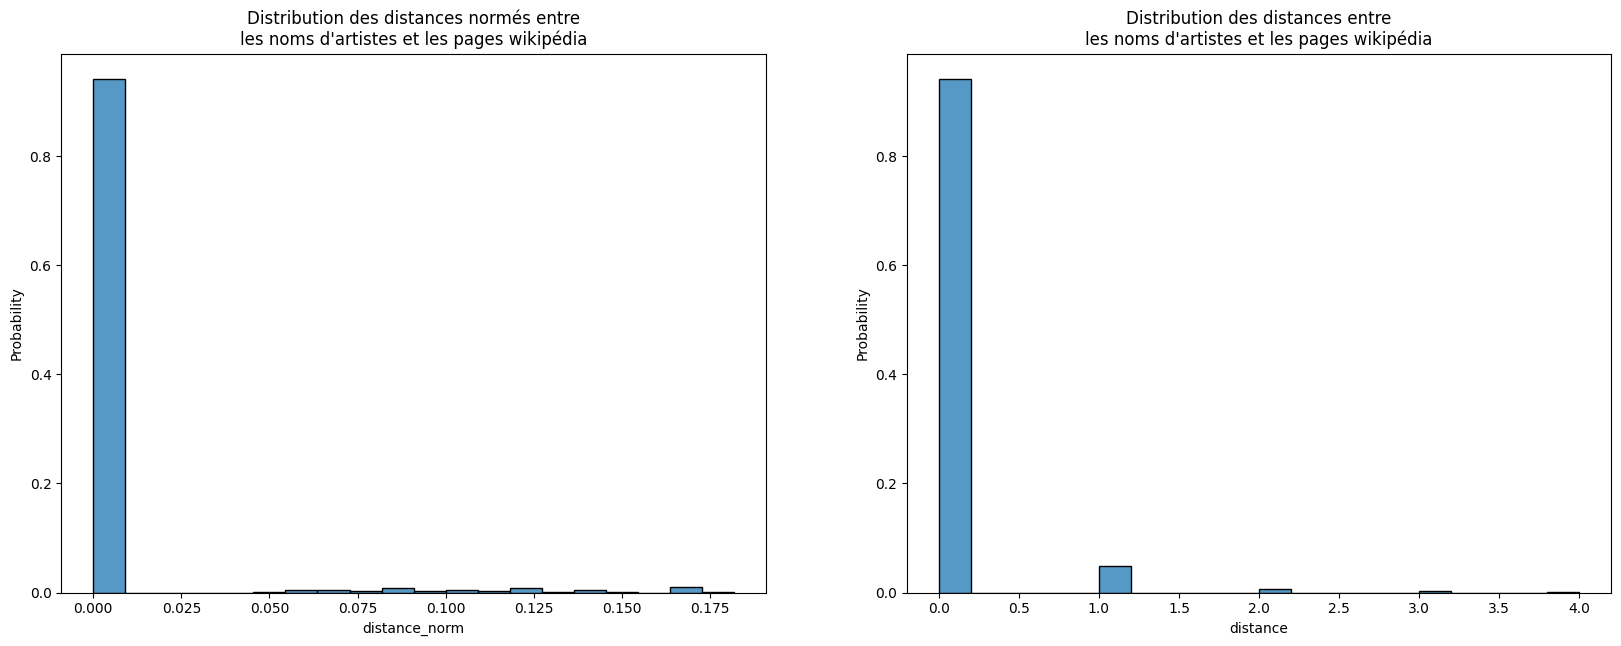

In [968]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(x = "distance_norm", data=artist, bins=20, stat="probability", ax=ax[0])
ax[0].set_title("Distribution des distances normés entre\nles noms d'artistes et les pages wikipédia")

sns.histplot(x = "distance", data=artist, bins=20, stat="probability", ax=ax[1])
ax[1].set_title("Distribution des distances entre\nles noms d'artistes et les pages wikipédia")

plt.show()

## Nationalité/Pays

In [969]:
nationality_cols = ["Nationalité", "Origine", "Pays", "Pays d'origine"]

### Artiste sans donnée

In [970]:
#Ajout de la colonne "No data" pour voir ceux sur qui on n'a pas de données
artist["No data"] = (
    (artist["Naissance"].isna()) &
    (artist["Pays d'origine"].isna()) &
    (artist["Origine"].isna()) &
    (artist["Nationalité"].isna()) &
    (artist["Pays"].isna()) &
    (artist["Summary"].isna())
)

In [971]:
artist["No data"].value_counts(normalize=True).round(2) #On a 4% des artistes sans données

False    0.96
True     0.04
Name: No data, dtype: float64

In [972]:
charts_c = charts.copy().merge(artist, left_on="Artist", right_on="Artist", how="right")

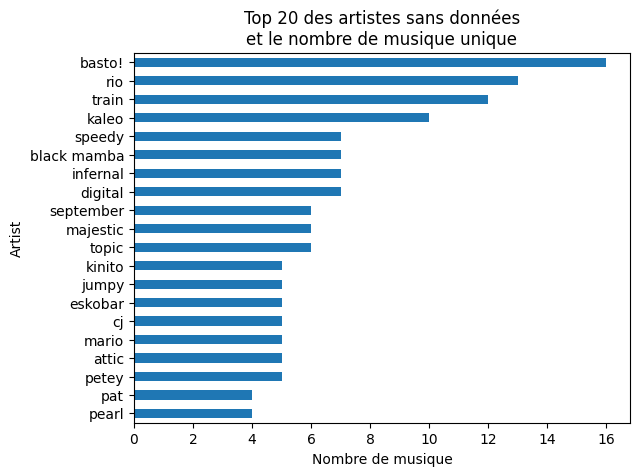

In [973]:
charts_c[charts_c["No data"]].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes sans données\net le nombre de musique unique")
plt.xlabel("Nombre de musique")
plt.show()

In [974]:
artist = artist[~artist["No data"]] #On ne garde que les artistes pour lesquels on a des données

### Normalisation des nationalités et pays récupéré

In [975]:
def category_count(cols, df, figsize=(40,7), top=10):
    length = []
    for col in cols:
        length.append(len(df[col].unique()))

    fig, ax = plt.subplots(1, len(cols)+1, figsize=figsize)

    sns.barplot(x=cols, y=length, ax=ax[0])
    ax[0].set_title("Nombre de valeurs différentes pour chaque colonne")

    for axi, col in zip(ax[1:], cols):
        df[col].value_counts().head(top)[::-1].plot.barh(ax=axi)
        axi.set(title=f"Top {top} de {col}", xlabel="Nombre d'occurence")
        axi.set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in axi.get_yticklabels()])

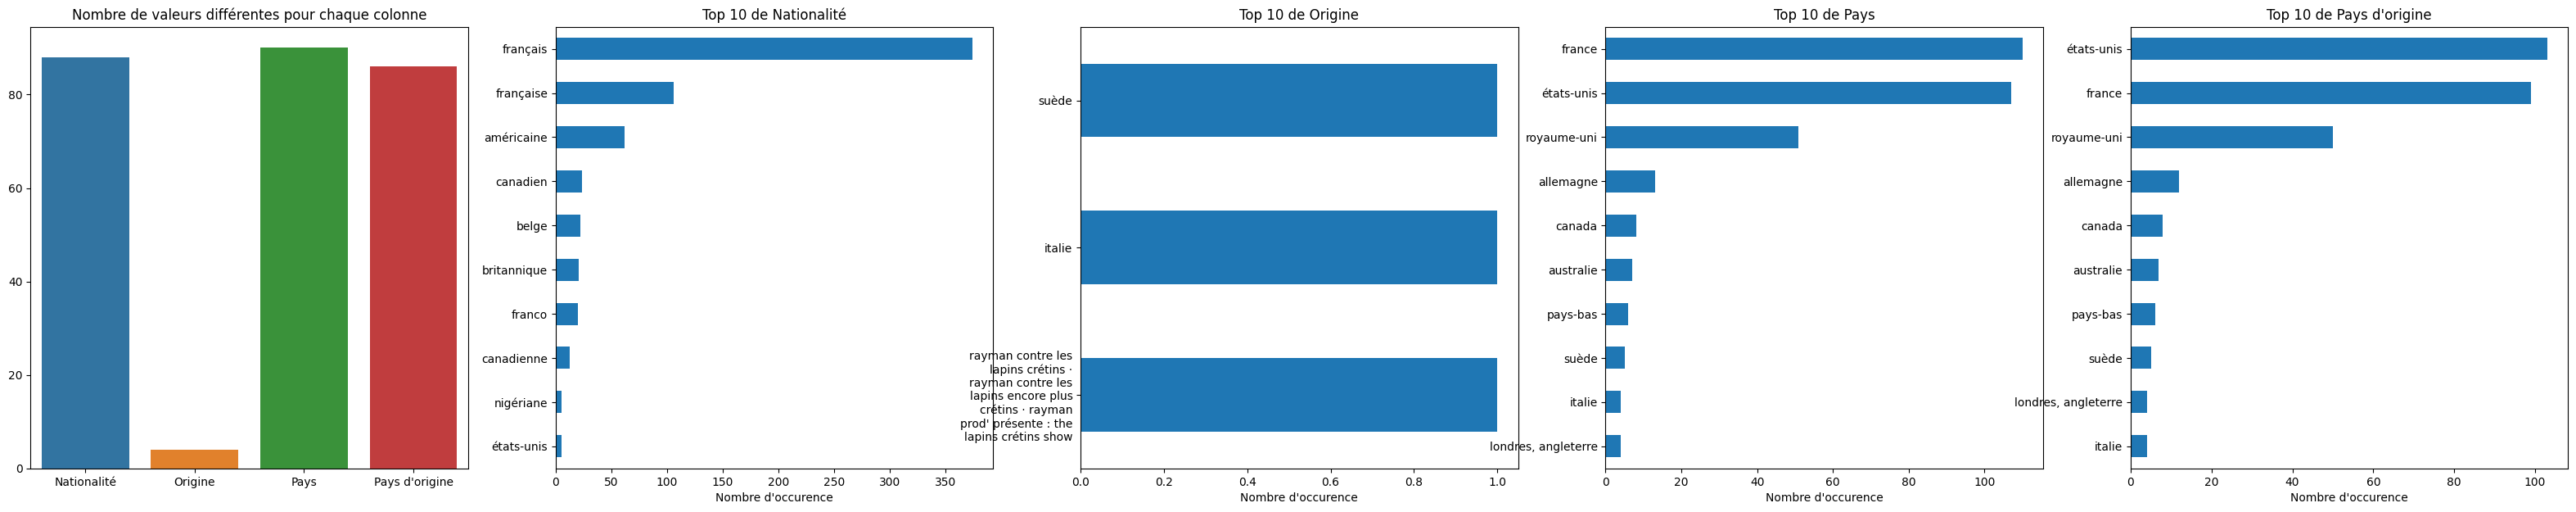

In [976]:
category_count(nationality_cols, artist)

On se rends compte qu'il y a pleins de nationalité/pays différents et qu'on pourrait en grouper certain.

In [977]:
#On supprime les textes dépassant les 40 caractères
for col in nationality_cols:
    artist.loc[~artist[col].isna(), col] = artist.loc[~artist[col].isna(), col].apply(lambda x: np.NaN if len(x) > 40 else x)

In [978]:
#Importation des pays et des gentillé associer
gentille_df = pd.read_csv("../monde/gentille.csv")
gentille = gentille_df["gentille"].tolist()
pays = gentille_df["pays"].tolist()

In [979]:
#On cherche dans les pays si on trouve quelque chose de connu
for p in pays:
    rgx = r"([\d)()\], ]|^)"+ p.lower() + r"([.,\[) ]|$)"
    artist.loc[artist["Pays"].str.contains(rgx, regex=True, na=False), "Pays"] = p
    artist.loc[artist["Pays d'origine"].str.contains(rgx, regex=True, na=False), "Pays d'origine"] = p

C:\Users\quent\AppData\Local\Temp\ipykernel_14064\3502182545.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artist.loc[artist["Pays"].str.contains(rgx, regex=True, na=False), "Pays"] = p
C:\Users\quent\AppData\Local\Temp\ipykernel_14064\3502182545.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artist.loc[artist["Pays d'origine"].str.contains(rgx, regex=True, na=False), "Pays d'origine"] = p


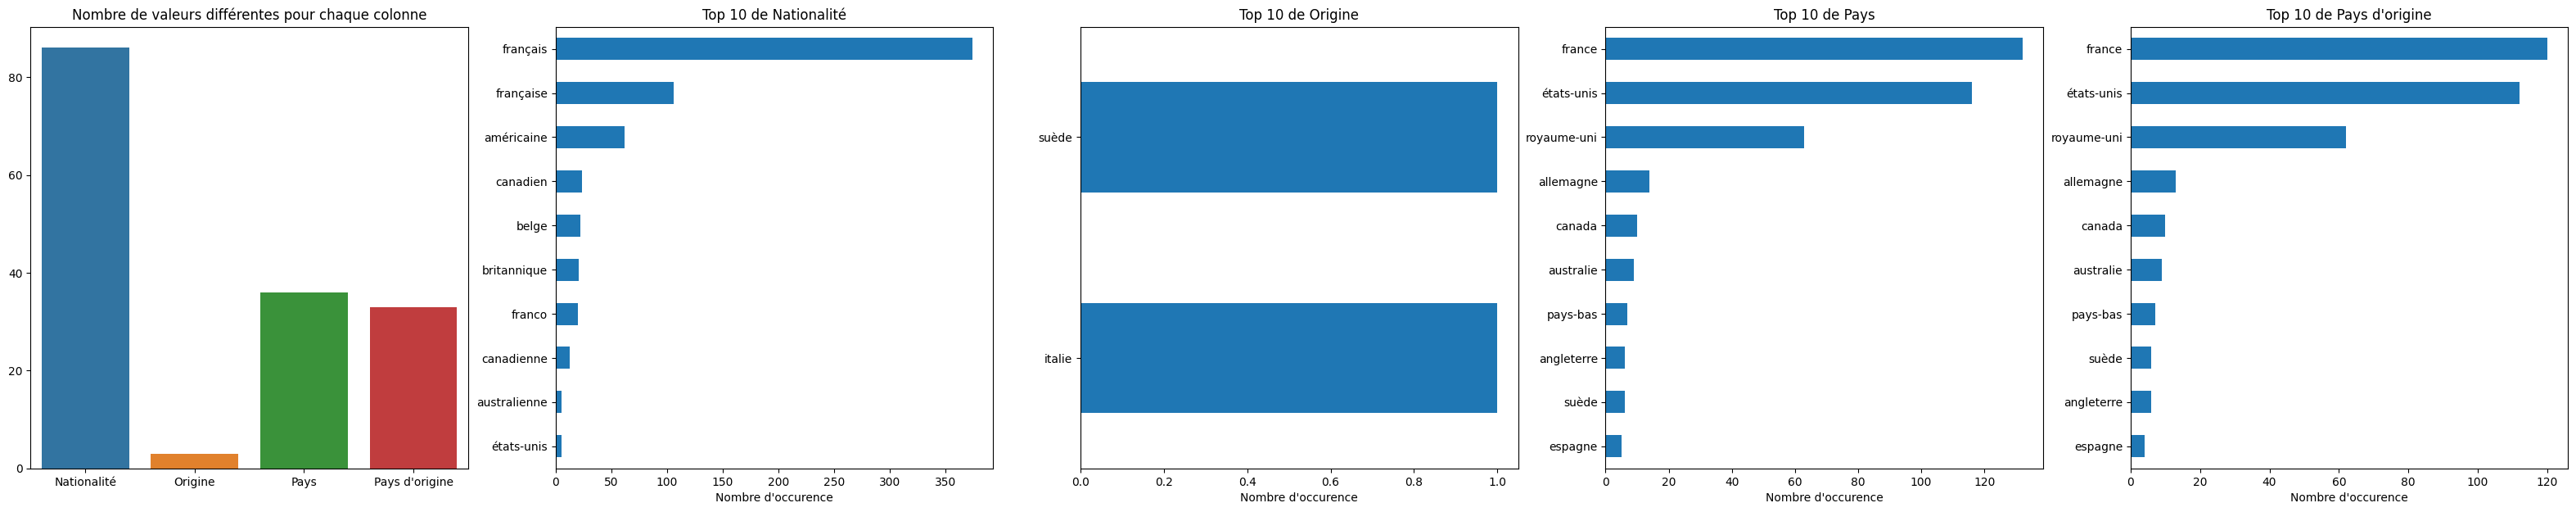

In [980]:
category_count(nationality_cols, artist)

On a enlevé les valeurs aberrantes et réduit de moitié pays et pays d'origne.

In [981]:
#Cela va permettre de normaliser les noms des pays et des nationalités
def cleanning(data, replace_words, p=0.3):
    if data is np.NaN:
        return np.NaN
    
    distances = []
    for r in replace_words:
        distances.append(edit_distance(data.lower(), r.lower())/len(data))
    return replace_words[np.argmin(distances)] if np.min(distances) < p else np.NaN

In [982]:
artist["Nationalité"] = artist["Nationalité"].apply(lambda x : cleanning(x, gentille))

In [983]:
artist["Origine"] = artist["Origine"].apply(lambda x : cleanning(x, pays))
artist["Pays"] = artist["Pays"].apply(lambda x : cleanning(x, pays))
artist["Pays d'origine"] = artist["Pays d'origine"].apply(lambda x : cleanning(x, pays))

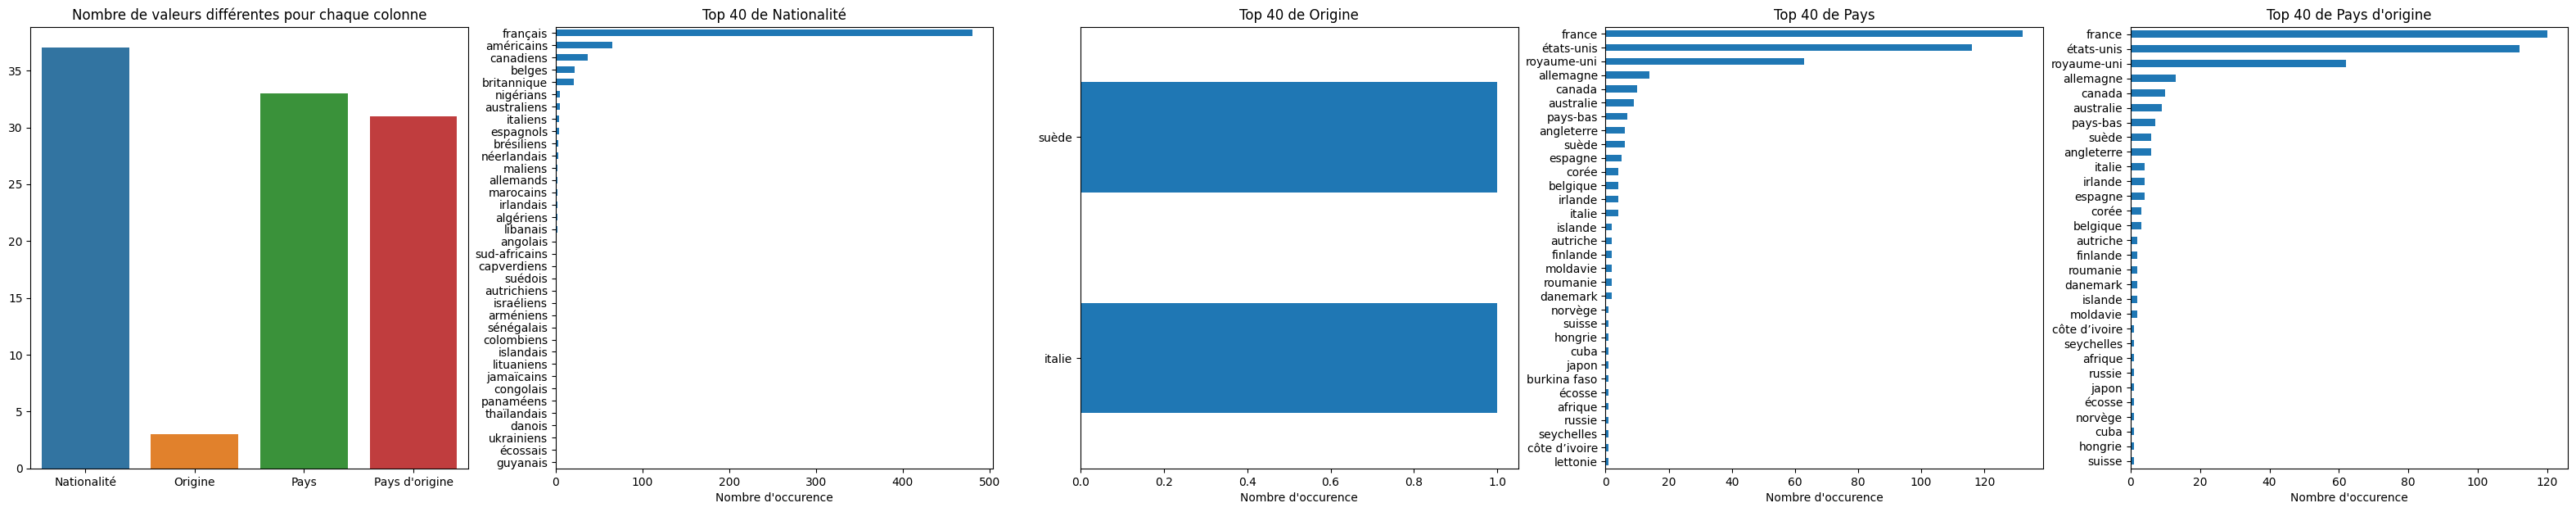

In [984]:
category_count(nationality_cols, artist, top=40)

### Récupération de nouvelles nationalités et pays

Maintenant que nous avons normalisé l'écriture des pays et nationalité on va essayer d'en chercher de nouveau pour les artistes qui n'en n'ont pas. A l'aide du summary et naissance.

In [985]:
artist["No nationality"] = (
    (artist["Nationalité"].isna()) &
    (artist["Origine"].isna()) &
    (artist["Pays"].isna()) &
    (artist["Pays d'origine"].isna())
)

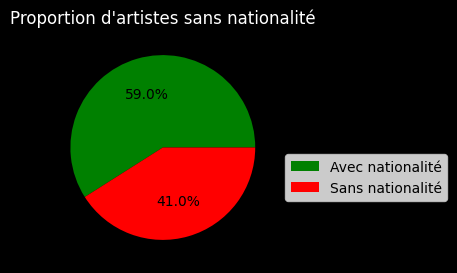

In [986]:
artist.value_counts("No nationality", normalize=True).round(2).plot.pie(autopct="%1.1f%%", figsize=(3,3), colors=["green", "red"]) #On a 41% des artistes sans nationalité
plt.title("Proportion d'artistes sans nationalité", color='white')
plt.gcf().set_facecolor('black')
plt.legend(["Avec nationalité", "Sans nationalité"], bbox_to_anchor=(1, 0.5))

In [987]:
def get_nationality(data_to_check, check_list):
    if data_to_check is np.NaN:
        return np.NaN
        
    for r in check_list:
        regex = r"([\d)()\], ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, data_to_check.lower()) is None:
            return r.lower()
    return np.NaN

In [988]:
#On utilise le summary pour récupérer la nationalité
avant = artist[artist["Nationalité"].isna()].shape[0]

nats = artist[~artist["Nationalité"].isna()]["Nationalité"].unique()
artist.loc[artist["Nationalité"].isna(), "Nationalité"] = artist.loc[artist["Nationalité"].isna(), "Summary"].apply(lambda x: get_nationality(x, nats))         #Je récupère une première fois avec les nationalités déjà connues
artist.loc[artist["Nationalité"].isna(), "Nationalité"] = artist.loc[artist["Nationalité"].isna(), "Summary"].apply(lambda x: get_nationality(x, gentille))     #Je récupère une deuxième fois avec les gentilles

apres = artist[artist["Nationalité"].isna()].shape[0]

print(f"On a récupéré {avant-apres} nationalités")

On a récupéré 175 nationalités


In [989]:
#On utilise le summary pour récupérer la Pays
avant = artist[(artist["Pays"].isna()) & (artist["Nationalité"].isna())].shape[0]

artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Pays"] = artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Naissance"].apply(lambda x: get_nationality(x, pays)) #Je récupère une première fois sur les naissances
artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Pays"] = artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Summary"].apply(lambda x: get_nationality(x, pays))   #Je récupère une deuxième fois sur le summary

apres = artist[(artist["Pays"].isna()) & (artist["Nationalité"].isna())].shape[0]

print(f"On a récupéré {avant - apres} pays")

On a récupéré 403 pays


In [990]:
#Mise à jour
artist["No nationality"] = (
    (artist["Nationalité"].isna()) &
    (artist["Origine"].isna()) &
    (artist["Pays"].isna()) &
    (artist["Pays d'origine"].isna())
)

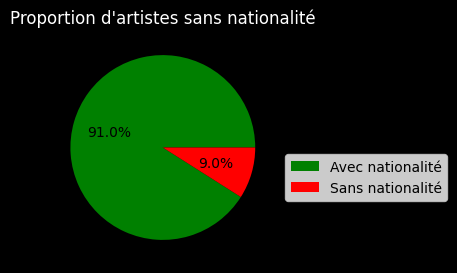

In [991]:
artist.value_counts("No nationality", normalize=True).round(2).plot.pie(autopct="%1.1f%%", figsize=(3,3), colors=["green", "red"]) #On a 41% des artistes sans nationalité
plt.title("Proportion d'artistes sans nationalité", color='white')
plt.gcf().set_facecolor('black')
plt.legend(["Avec nationalité", "Sans nationalité"], bbox_to_anchor=(1, 0.5))

In [992]:
avant = artist[artist["Nationalité"].isna()].shape[0]

In [993]:
#On récupère la nationalité à partir du pays et origine
gentille = pd.DataFrame.to_dict(gentille_df.set_index("pays"), orient="dict").get("gentille")

for k, v in gentille.items():
    artist.loc[(artist["Nationalité"].isna()) & (artist["Pays"] == k), "Nationalité"] = v
    artist.loc[(artist["Nationalité"].isna()) & (artist["Pays d'origine"] == k), "Nationalité"] = v
    artist.loc[(artist["Nationalité"].isna()) & (artist["Origine"] == k), "Nationalité"] = v

In [994]:
apres = artist[artist["Nationalité"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalités")

On a récupéré 631 nationalités


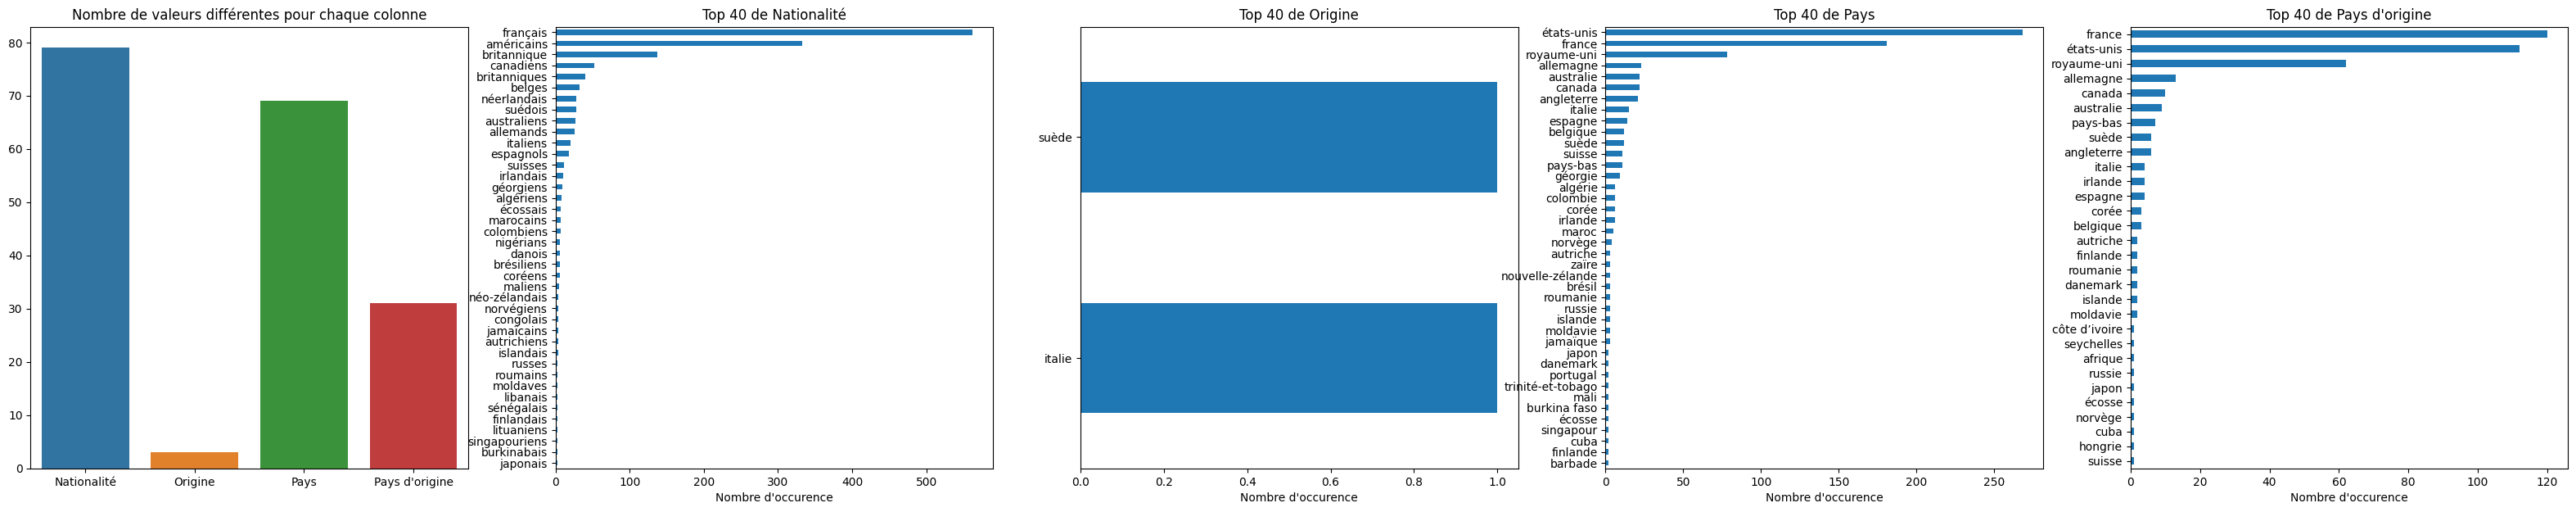

In [995]:
category_count(nationality_cols, artist, top=40)

In [866]:
artist[(artist["Nationalité"].isna()) & (~artist["Naissance"].isna())].to_csv("../artist_missing.csv", encoding="utf-8-sig")
charts_c = charts.copy().merge(artist, left_on="Artist", right_on="Artist", how="left").drop(columns=["Rank","Annee", "Mois"]).drop_duplicates()
charts_c[charts_c["Nationalité"].isna()].groupby("Artist")["Music"].count().sort_values(ascending=False)

## Departement/Region/Commune

In [947]:
#Load
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig", index_col=0)

In [ ]:
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/communes-departement-region.csv")
nb_habitant = pd.read_csv("../france/nb_habitant.csv")

In [ ]:
#On supprime les colonnes inutiles
commune = commune.drop(columns = ["code_commune_INSEE", "nom_commune_postal", "code_postal", "libelle_acheminement", "ligne_5", "latitude", "longitude", "code_commune", "article", "code_departement", "code_region", "nom_commune"])

#On rename la colonne nom_commune_complet en nom_commune
commune = commune.rename(columns={"nom_commune_complet": "nom_commune"})

#On enleve les arrondisement des villes
commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"] = commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"].str[:-3]

#On ajoute le nombre d'habitant au commune
commune = commune.merge(nb_habitant[["Ville", "nb_habitant"]], left_on="nom_commune", right_on="Ville", how="inner").drop(columns=["Ville"]).dropna().drop_duplicates()

#On transforme le nb d'habitant en int
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

#On transforme tout en lower
for col in commune.select_dtypes("object").columns:
    commune[col] = commune[col].str.lower()

In [ ]:
def get_localisation(row, localisation):
    for r in localisation:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if (not re.search(regex, row["Summary"].lower()) is None) or (not re.search(regex, row["Naissance"].lower()) is None):
            return r.lower()
    return np.NaN

In [ ]:
artist["Region"] = artist.apply(lambda x: get_localisation(x, commune["nom_region"]), axis=1)

In [ ]:
artist["Commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["nom_commune"]), axis=1)

In [ ]:
artist["Departement"] = artist.apply(lambda x: get_localisation(x, commune["nom_departement"]), axis=1)

In [ ]:
for col in ["Region", "Commune", "Departement"]:
    print("-"*50)
    print(col)
    print("-"*50)
    print(artist[col].value_counts().drop(index=[MISSING]))
    print("Total : ", artist[col].value_counts()[1:].sum())

--------------------------------------------------
Region
--------------------------------------------------
guadeloupe                    7
guyane                        5
bretagne                      3
provence-alpes-côte d'azur    3
martinique                    3
normandie                     2
hauts-de-france               2
la réunion                    1
corse                         1
pays de la loire              1
île-de-france                 1
Name: Region, dtype: int64
Total :  29
--------------------------------------------------
Commune
--------------------------------------------------
paris          80
marseille      21
nice           11
lyon            8
saint-denis     7
               ..
courbevoie      1
pontoise        1
lens            1
colomiers       1
yerres          1
Name: Commune, Length: 210, dtype: int64
Total :  439
--------------------------------------------------
Departement
--------------------------------------------------
paris                85


In [ ]:
artist["No localisation"] = (
    (artist["Region"] == MISSING) &
    (artist["Commune"] == MISSING) &
    (artist["Departement"] == MISSING)
)

In [ ]:
# Les artistes pour qui ont a trouvé une commune/departement/region on leur donne la nationalité française
artist.loc[(artist["Nationalité"] == MISSING) & (~artist["No localisation"]), "Nationalité"] = "français"

In [ ]:
def commune_to_departement(x : str):
    value = commune.loc[commune["nom_commune"] == x, "nom_departement"].values
    if len(value) > 0:
        return value[0]
    else:
        return MISSING

In [ ]:
#On ajoute les departements pour les communes
artist.loc[(artist["Commune"] != MISSING) & (artist["Departement"] == MISSING), "Departement"] = artist.loc[(artist["Commune"] != MISSING) & (artist["Departement"] == MISSING), "Commune"].apply(commune_to_departement)

In [ ]:
def departement_to_region(x : str):
    value = commune.loc[commune["nom_departement"] == x, "nom_region"].values
    if len(value) > 0:
        return value[0]
    else:
        return MISSING

In [ ]:
#On ajoute les regions pour les departements
artist.loc[(artist["Departement"] != MISSING) & (artist["Region"] == MISSING), "Region"] = artist.loc[(artist["Departement"] != MISSING) & (artist["Region"] == MISSING), "Departement"].apply(departement_to_region)

In [ ]:
artist["No localisation"] = (
    (artist["Region"] == MISSING) &
    (artist["Commune"] == MISSING) &
    (artist["Departement"] == MISSING)
)

In [ ]:
artist[artist["No localisation"]].to_csv("../artist_no_localisation.csv", encoding="utf-8-sig")

In [ ]:
artist[artist["No localisation"]].value_counts("Nationalité")

Nationalité
                151
français        148
américains      137
néerlandais     134
britanniques    125
               ... 
bosniaques        1
biélorusses       1
guinéens          1
panaméens         1
ivoiriens         1
Length: 81, dtype: int64

# Etape 4 : Cleanning wikipedia results

In [944]:
#Load
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/nationalité_pays/artist.csv", encoding="utf-8-sig", index_col=0)

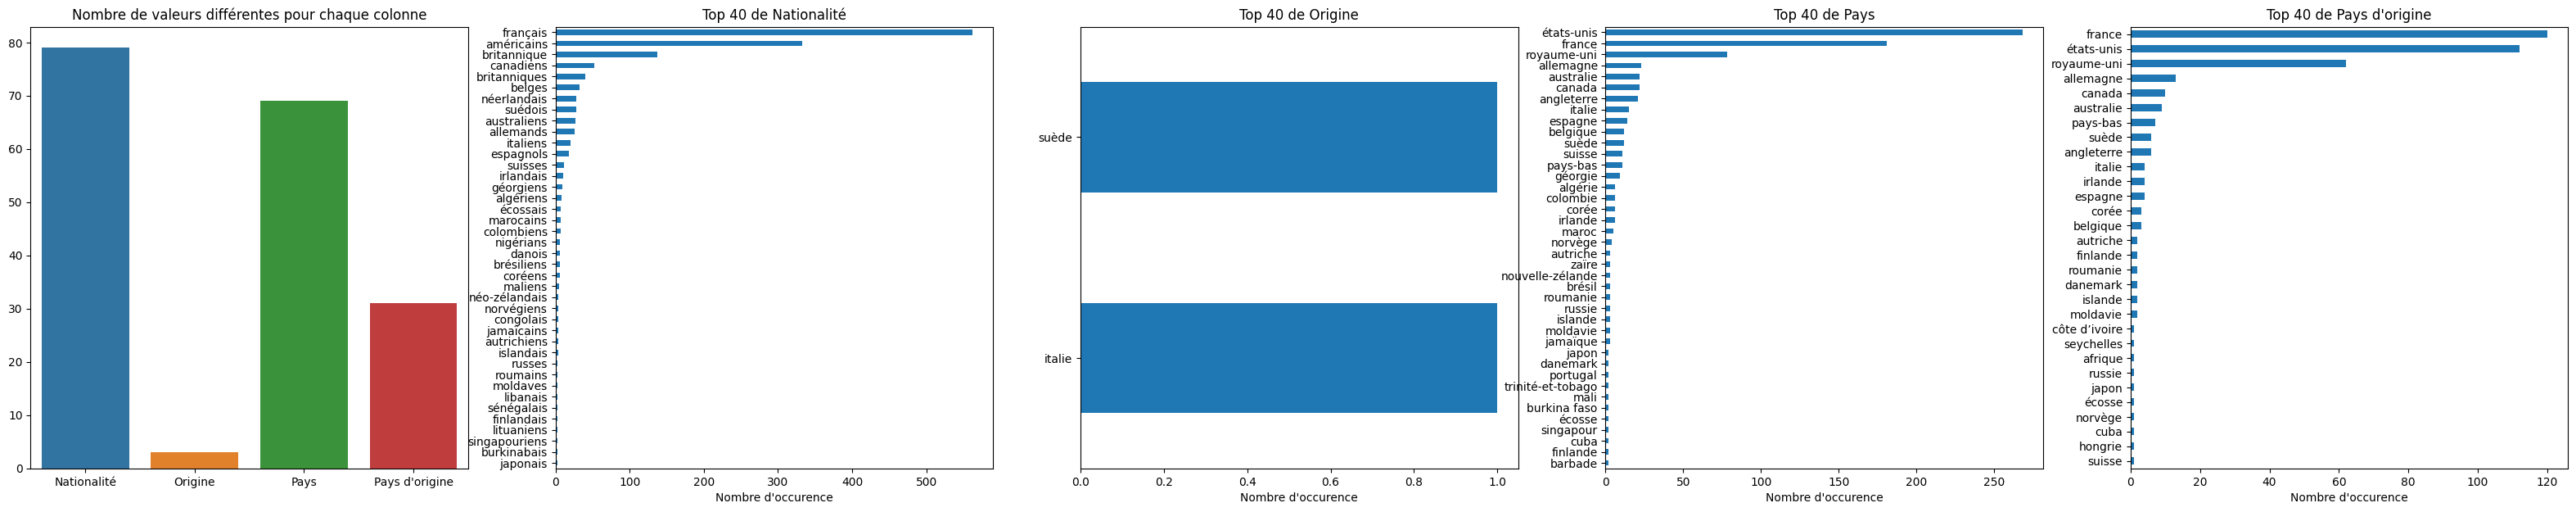

In [946]:
category_count(nationality_cols, artist, top=40)